# Amazon Products Recommendation system

**Afshin Bayatpour, email: afshin.bayatpour@gmail.com**

## imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from surprise import KNNWithMeans, KNNBasic, KNNWithZScore, KNNBaseline
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import SVD

#### Recommeder system creates a similarity between the user and items and exploits the similarity between user/item to make recommendations.

What recommeder system can solve ?

**1.It can help the user to find the right product.**\
**2.It can increase the user engagement. For example, there's 40% more click on the google news due to recommendation.**\
**3.It helps the item providers to deliver the items to the right user.In Amazon , 35 % products get sold due to recommendation.**\


## data exploring

In [2]:
df = pd.read_csv(r'D:\Bootcamp\capstone\amazon\ratings_Electronics.csv')

In [3]:
df.columns = ['User_id', 'product_id', "rating", "timestamp"]
df=df.drop(['timestamp'],axis=1)

In [4]:
df.head()

,User_id,product_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   User_id     object 
 1   product_id  object 
 2   rating      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
df.describe()

,rating
count,7.824481e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [7]:
df.isna().sum()

User_id       0
product_id    0
rating        0
dtype: int64

In [8]:
user_num=len(df['User_id'].unique())
product_num=len(df['product_id'].unique())
print(f"The number of Unique Users: {user_num}")
print(f"number of unique products: {product_num}")

The number of Unique Users: 4201696
number of unique products: 476001


In [9]:
print(df["rating"].describe())

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [10]:
rating_stat=df.groupby(df.rating).count()
print(rating_stat)

        User_id  product_id
rating                     
1.0      901765      901765
2.0      456322      456322
3.0      633073      633073
4.0     1485781     1485781
5.0     4347540     4347540


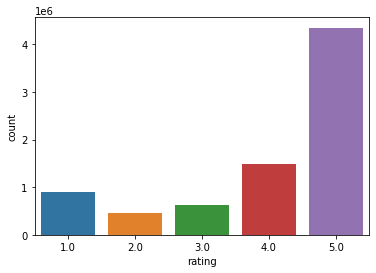

In [11]:
sns.countplot(df['rating']);

### finding the users that gave the most ratings


In [12]:
user_rating_count = df.groupby('User_id')['rating'].count().sort_values(ascending=False)
user_rating_count

User_id
A5JLAU2ARJ0BO            520
ADLVFFE4VBT8             501
A3OXHLG6DIBRW8           498
A6FIAB28IS79             431
A680RUE1FDO8B            406
                        ... 
A3AAXZAK8EB9KG             1
A3AAXY0TMZS72Y             1
A3AAXX0N47FFP              1
A3AAXWHVCN6VOG             1
A00000262KYZUE4J55XGL      1
Name: rating, Length: 4201696, dtype: int64

In [13]:
user_rating_count = df.groupby('User_id')['rating'].count()


In [14]:
user_rating_count.describe()

count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: rating, dtype: float64

### finding the items that received the most ratings


In [15]:
item_rating_count = df.groupby('product_id')['rating'].count().sort_values(ascending=False)
item_rating_count

product_id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B0058FM5IM        1
B0058FM320        1
B0058FM0M8        1
B0058FM05U        1
0321732944        1
Name: rating, Length: 476001, dtype: int64

In [16]:
item_rating_count = df.groupby('product_id')['rating'].count()


In [17]:
item_rating_count.describe()

count    476001.000000
mean         16.437951
std         112.702749
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       18244.000000
Name: rating, dtype: float64

In [18]:
new_df = df.join(user_rating_count, on='User_id', rsuffix='_user_count')
data = new_df.join(item_rating_count, on='product_id', rsuffix='_item_count')


In [19]:
data

,User_id,product_id,rating,rating_user_count,rating_item_count
0,A2CX7LUOHB2NDG,0321732944,5.0,4,1
1,A2NWSAGRHCP8N5,0439886341,1.0,1,3
2,A2WNBOD3WNDNKT,0439886341,3.0,1,3
3,A1GI0U4ZRJA8WN,0439886341,1.0,1,3
4,A1QGNMC6O1VW39,0511189877,5.0,2,6
...,...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,2,15
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,2,15
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,19,15
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1,15


In [20]:
data_final=data[(data['rating_user_count'] >= 50) & (data['rating_item_count'] >= 50)] 
data_final

,User_id,product_id,rating,rating_user_count,rating_item_count
491,A3CLWR1UUZT6TG,0972683275,5.0,58,1051
630,A3TAS1AG6FMBQW,0972683275,5.0,163,1051
1002,A2Y4H3PXB07WQI,0972683275,4.0,50,1051
1137,A25RTRAPQAJBDJ,0972683275,5.0,54,1051
1309,A3LDPF5FMB782Z,1400501466,5.0,69,250
...,...,...,...,...,...
7824207,A3R1WFO4KIUQXZ,B00L3YHF6O,5.0,134,70
7824208,A3S3R88HA0HZG3,B00L3YHF6O,5.0,137,70
7824211,A2XRMQA6PJ5ZJ8,B00L3YHF6O,5.0,253,70
7824215,A3A4ZAIBQWKOZS,B00L3YHF6O,5.0,236,70


In [21]:
data_final["product_id"].unique().shape

(16993,)

### Popularity based recommendation


#### Popularity based systems: It works by recommending items viewed and purchased by most people and are rated high. It is not a personalized recommendation.

#### Average rating of the product 


In [22]:
popularity_base_rating = pd.DataFrame(data.groupby('product_id')['rating'].mean())
popularity_base_rating['rating_counts'] = pd.DataFrame(data.groupby('product_id')['rating'].count())
popularity_base_rating = popularity_base_rating.sort_values(["rating_counts", "rating"], ascending=False)
popularity_base_rating.head(10)

,rating,rating_counts
product_id,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226
B003ELYQGG,4.392528,11617
B003ES5ZUU,4.704749,10276
B007R5YDYA,4.690926,9907
B00622AG6S,4.420136,9823


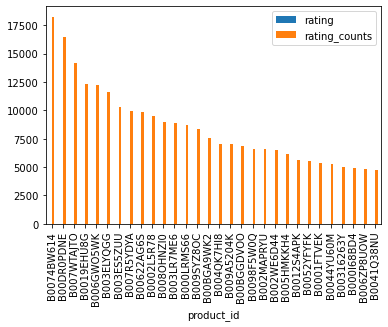

In [23]:
popularity_base_rating.head(30).plot(kind = "bar")

Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)]\
where,\
v is the number of rating for the movie;\
m is the minimum ratings required to be listed in the chart;\
R is the average rating of the movie; and\
C is the mean rating across the whole report.\
Now we find the values of v,m,R,C.

In [24]:
C= popularity_base_rating['rating'].mean()
m= popularity_base_rating['rating_counts'].quantile(0.9)
q_popularity_base_rating = popularity_base_rating.loc[popularity_base_rating['rating_counts'] >= m]
q_popularity_base_rating.shape

(48174, 2)

In [25]:
def weighted_rating(x, m=m, C=C):
    v = x['rating_counts']
    R = x['rating']
    return (v/(v+m) * R) + (m/(m+v) * C)
q_popularity_base_rating['score'] = q_popularity_base_rating.apply(weighted_rating, axis=1)
 
 
#Sorting movies based on score calculated above
q_popularity_base_rating = q_popularity_base_rating.sort_values('score', ascending=False)
#Printing the top 15 movies
q_popularity_base_rating.loc[:,[ 'rating_counts', 'rating', 'score']].head(10)

    

<ipython-input-25-33ea174141a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q_popularity_base_rating['score'] = q_popularity_base_rating.apply(weighted_rating, axis=1)


,rating_counts,rating,score
product_id,,,
B0043WJRRS,2512,4.881369,4.871597
B00CG70K78,237,4.949367,4.848254
B007SZ0E1K,449,4.895323,4.842284
B003FVVMS0,1876,4.853412,4.840738
B0033PRWSW,387,4.901809,4.840394
B008VGCT9K,230,4.939130,4.836245
B0029N3U8K,658,4.869301,4.833444
B0041OYTJE,458,4.879913,4.828659
B00GMRCAC6,187,4.951872,4.826615


### Collaborative  Filtering model



#### Collaborative Filtering: - It is based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste. it is mainly of two types: a) User-User b) Item -Item

KNNWithMeans: KNNWith means is a nearest neighbour mapping method , that is used to recommend users the products based on the what your closest neighbour has bought/liked.\
The similarity between user/item is calculated for each user either based on cosine similiarity or using pearson correlation coefficient. Depending on the values of these parameters the products are suggested to the user.

In [26]:
reader = Reader(rating_scale=(1, 5))
data_collaborative = Dataset.load_from_df(data_final[["User_id", "product_id", "rating" ]],reader)

KNNBasic: A basic collaborative filtering algorithm.\
KNNWithMeans: A basic collaborative filtering algorithm, taking into account the mean ratings of each user.\
KNNWithZScore: A basic collaborative filtering algorithm, taking into account the z-score normalization of each user.\
KNNBaseline: A basic collaborative filtering algorithm taking into account a baseline rating.



In [27]:
# item-item collaborating filtering (finds the k most similar items)
uu_models = []
uu_models.append(('KNNWithMeans',KNNWithMeans(k=5, sim_options={'name': 'cosine', 'user_based': False})))
uu_models.append(('KNNBasic', KNNBasic(k=5, sim_options={'name': 'cosine', 'user_based': False})))
uu_models.append(('KNNWithZScore', KNNWithZScore(k=5, sim_options={'name': 'cosine', 'user_based': False})))
uu_models.append(('KNNBaseline', KNNBaseline(k=5, sim_options={'name': 'cosine', 'user_based': False})))

In [28]:
for model_name, model in uu_models:
    print("**** ", model_name)
    cross_validate(model, data_collaborative, measures=['RMSE', 'MAE'], cv=5, verbose=True)

****  KNNWithMeans
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1170  1.0998  1.1044  1.1135  1.1131  1.1096  0.0064  
MAE (testset)     0.7724  0.7633  0.7656  0.7654  0.7704  0.7674  0.0034  
Fit time          19.11   22.07   18.71   14.90   15.60   18.08   2.59    
Test time         1.21    1.30    1.38    1.45    1.09    1.29    0.13    
****  KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matr

In [29]:
trainset,testset =train_test_split(data_collaborative, test_size=0.2,random_state=1)

In [30]:
model = KNNBaseline(k=5, sim_options={'name': 'cosine', 'user_based': False})
model.fit(trainset)
test_pred = model.test(testset)
print("RMSE of ", model_name)
accuracy.rmse(test_pred, verbose=True)
accuracy.mae(test_pred, verbose=True)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE of  KNNBaseline
RMSE: 1.0305
MAE:  0.7295


0.72952389787791

In [31]:
# Parameters:
# uid – The (raw) user id. See this note.
# iid – The (raw) item id. See this note.
# r_ui (float) – The true rating rui.
# est (float) – The estimated rating r^ui.
# details (dict) – Stores additional details about the prediction that might be useful for later analysis. -->

In [32]:
from collections import defaultdict

def get_top_n_recommendations(reccomemndations, n=5):
    # First map the reccommendations to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in reccomemndations:
        top_n[uid].append((iid, est))

    #sort predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [33]:
#getting top 5 recommendations for users 
get_top_n_recommendations(test_pred, n=5)

defaultdict(list,
            {'A10AFVU66A79Y1': [('B000F34FVM', 4.779164223395211),
              ('B002HEWA28', 4.701951225681273),
              ('B0023B14TK', 4.646781833360093),
              ('B002V88HFE', 4.363895966200223),
              ('B00INNP5VU', 4.358204063694293)],
             'A3MQAQT8C6D1I7': [('B000E6NGBU', 5),
              ('B003FVVMS0', 5),
              ('B0012GK3MQ', 4.989423373068885),
              ('B008ULPE70', 4.914057176355984),
              ('B009Z8VYB2', 4.702852580271454)],
             'AOTZOHB2LZGYR': [('B007CS9WYI', 4.960434308279639),
              ('B006EWUO22', 4.857549323472753),
              ('B001E0JH5E', 4.8433851653247695),
              ('B006VAD2C6', 4.759405662942788),
              ('B0026ZPFCK', 4.529878633030723)],
             'A1HFT68GJ42LTM': [('B00CB2F65O', 4.37157018284554),
              ('B000MUXVZO', 4.2696703570827435),
              ('B0081FLFQE', 4.0262028131061625),
              ('B001IWOBA4', 3.928722466017319),
       

In [34]:
# user-user collaborating filtering (finds the k most similar users)
ii_models = []
ii_models.append(('KNNWithMeans',KNNWithMeans(k=5, sim_options={'name': 'cosine', 'user_based': True})))
ii_models.append(('KNNBasic', KNNBasic(k=5, sim_options={'name': 'cosine', 'user_based': True})))
ii_models.append(('KNNWithZScore', KNNWithZScore(k=5, sim_options={'name': 'cosine', 'user_based': True})))
ii_models.append(('KNNBaseline', KNNBaseline(k=5, sim_options={'name': 'cosine', 'user_based': True})))

In [35]:
for model_name, model in ii_models:
    print("**** ", model_name)
    cross_validate(model, data_collaborative, measures=['RMSE', 'MAE'], cv=5, verbose=True)

****  KNNWithMeans
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0432  1.0548  1.0489  1.0428  1.0270  1.0433  0.0092  
MAE (testset)     0.7346  0.7442  0.7376  0.7328  0.7257  0.7350  0.0061  
Fit time          0.73    0.71    0.63    0.79    0.66    0.70    0.05    
Test time         0.50    0.58    0.49    0.58    0.46    0.52    0.05    
****  KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matr

In [36]:
for model_name, model in ii_models:
    model.fit(trainset)
    test_pred = model.test(testset)
    print("RMSE of ", model_name)
    accuracy.rmse(test_pred, verbose=True)
    accuracy.mse(test_pred, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE of  KNNWithMeans
RMSE: 1.0422
MSE: 1.0862
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE of  KNNBasic
RMSE: 1.1055
MSE: 1.2222
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE of  KNNWithZScore
RMSE: 1.0442
MSE: 1.0904
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE of  KNNBaseline
RMSE: 1.0388
MSE: 1.0792


## matrix factorization 
#### less sensetive to sparse and noisy data.\ 
#### Needs less computational power


In [37]:
model = SVD()
cross_validate(model, data_collaborative, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9669  0.9514  0.9688  0.9548  0.9461  0.9576  0.0088  
MAE (testset)     0.7066  0.6982  0.7071  0.6981  0.6943  0.7008  0.0051  
Fit time          4.52    4.38    4.40    4.76    5.05    4.62    0.25    
Test time         0.15    0.12    0.13    0.17    0.34    0.18    0.08    


{'test_rmse': array([0.96694871, 0.9514441 , 0.96880742, 0.95481089, 0.94609947]),
 'test_mae': array([0.70659897, 0.69823023, 0.70705764, 0.698097  , 0.69425866]),
 'fit_time': (4.515324115753174,
  4.3822479248046875,
  4.399408578872681,
  4.7592384815216064,
  5.0475077629089355),
 'test_time': (0.15396952629089355,
  0.12170553207397461,
  0.12563085556030273,
  0.16954970359802246,
  0.3370997905731201)}